# FORCE 2020 LITHOLOGY CLASSIFICATION COMPETITION
WELL - input well 
DEPTH_MD - non-corrected measured depth 
FORCE_2020_LITHOFACIES_LITHOLOGY - input lithology assumed to reflect the GeoScout mudrock interpretation  
FORCE_2020_LITHOFACIES_CONFIDENCE - uncertainty placed on the mudrock interpretation  

CALI - borehole measurement expect to be directly related to BS  
BS - borehole size  
GR - predominately correlates with lithology, minor linear relationship with depth  

DTC - 304804/x gives velocity in m/s, expect to have linear relationship with depth below mudline  
DTS - 304804/x gives velocity which should have a linear relationship with Vp  
NPHI - neutron porosity has a strong lithology correlation, bound water in shales results with high apparent porosity  
RHOB - density measurement, requires good contact with well edge meaning values can be bad when CALI-BS is large  

DRHO - Matrix density using for conversion from density porosity to density.  
RSHA - strongly affected by mud size and salinity  
RMED - logorithmic relationship with lithology and porosity, affected by mud contrast with formation salinity  
RDEP - similar to RMED, RDEP-RMED useful indication of hydrocarbons  

SP - relationship with pore fluids and mud salinity but also affected by lithology and hole condition  
PEF - relationship with lithology but also mud/wellbore condition  
ROP - penetration rate, correlation to formation hardness (density & porosity) and bit wear (linear with time)

Group - corresponds to a general age  
Formation - corresponds to lithology and a more specific age than group  
Mudweight - correlation with depth and formation pressure  
X_LOC, Y_LOC - spacial location can be used to generate 3D distribution of age with depth.
Z_LOC - the TVD below either the KB or the SL.

DCAL, SGR - Logs used as part of creating other logs  
RMIC, ROPA, RXO - Logs that contain drilling engineering information  

[Wikipedia](https://en.wikipedia.org/wiki/Petrophysics) description of petrophysics   
Canadian Well Logging Society [CWLS](https://www.spwla.org/SPWLA/Technical/Software/CANADIAN_WELL_LOGGING_SOCIETY.aspx)  
[CRAIN] (https://www.spec2000.net/index.htm) good resource for log properties  

## 3. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import lasio as ls
from welly import Project, Well

from pandas_profiling import ProfileReport
import ipywidgets as widgets
import missingno as msno


from xgboost import XGBClassifier, plot_importance, plot_tree
from matplotlib.pyplot import rcParams

## 4. Exploratory Data Analysis

### Open and review LAS files

In [2]:
# Open the LAS file
data_7 = ls.read(r'D:\Datasets\las_files_Lithostrat_data\7_1-1.las')

In [3]:
# Get the data sections
data_7.sections.keys()

dict_keys(['Version', 'Well', 'Curves', 'Parameter', 'Other'])

In [4]:
# Get the data from the section
for i in data_7.sections['Well']:
    print(f'{i.descr} ({i.mnemonic}): {i.value}')

 (STRT): 82.600799561
 (STOP): 2815.7912598
 (STEP): 0.152
 (NULL): -999.25
COMPANY (COMP): 
WELL (WELL): 7/1-1
FIELD (FLD): 
LOCATION (LOC): 
SERVICE COMPANY (SRVC): 
ss} (DATE): 2020-08-09 20:02:09   : Log Export Date {yyyy-MM-dd HH:mm
PROVINCE (PROV): 
UNIQUE WELL ID (UWI): 7/1-1
API NUMBER (API): 


In [5]:
# Get the data from the curves
for count, c in enumerate(data_7.curves):
    print(f'{c.descr}, ({c.mnemonic})')
print(f'Curves: {count+1}')

DEPTH, (DEPT)
FORCE_2020_LITHOFACIES_CONFIDENCE, (FORCE_2020_LITHOFACIES_CONFIDENCE)
FORCE_2020_LITHOFACIES_LITHOLOGY, (FORCE_2020_LITHOFACIES_LITHOLOGY)
CALI, (CALI)
BS, (BS)
DCAL, (DCAL)
MUDWEIGHT, (MUDWEIGHT)
ROP, (ROP)
RDEP, (RDEP)
RSHA, (RSHA)
RMED, (RMED)
SP, (SP)
DTC, (DTC)
NPHI, (NPHI)
GR, (GR)
RHOB, (RHOB)
DRHO, (DRHO)
DEPTH_MD, (DEPTH_MD)
x_loc, (X_LOC)
y_loc, (Y_LOC)
z_loc, (Z_LOC)
Curves: 21


In [6]:
# Transform the data to a dataframe
well_7 = data_7.df()
well_7.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 17982 entries, 82.600799561 to 2815.7127996
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FORCE_2020_LITHOFACIES_CONFIDENCE  16241 non-null  float64
 1   FORCE_2020_LITHOFACIES_LITHOLOGY   16242 non-null  float64
 2   CALI                               16270 non-null  float64
 3   BS                                 17947 non-null  float64
 4   DCAL                               16272 non-null  float64
 5   MUDWEIGHT                          15724 non-null  float64
 6   ROP                                17343 non-null  float64
 7   RDEP                               16121 non-null  float64
 8   RSHA                               16115 non-null  float64
 9   RMED                               16152 non-null  float64
 10  SP                                 16151 non-null  float64
 11  DTC                               

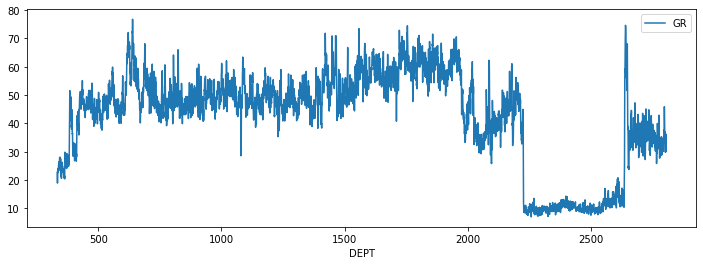

In [7]:
# Plot the data for instance Gamma Ray
well_7.plot(y='GR', figsize=(12, 4));

### Explore all LAS data files using WELLY

In [11]:
# Open all files from a folder
wells = Project.from_las('D:\Datasets\las_files_Lithostrat_data\*.las', index=0)

113it [07:47,  4.14s/it]
118it [04:39,  2.37s/it]


In [12]:
# Covert the data to a dataframe
wells_df = wells.df()
wells_df.shape

(1580837, 26)

In [13]:
# Explore the data
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1580837 entries, ('15/9-13', 25.0) to ('7/1-2 S', 3174.936400000855)
Data columns (total 26 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   FORCE_2020_LITHOFACIES_CONFIDENCE  972051 non-null   float64
 1   FORCE_2020_LITHOFACIES_LITHOLOGY   962396 non-null   float64
 2   CALI                               992628 non-null   float64
 3   MUDWEIGHT                          272280 non-null   float64
 4   ROP                                806328 non-null   float64
 5   RDEP                               1518996 non-null  float64
 6   RSHA                               560519 non-null   float64
 7   RMED                               1413566 non-null  float64
 8   RXO                                263411 non-null   float64
 9   SP                                 853321 non-null   float64
 10  DTC                                1215227 non-null

In [14]:
# Target variable can't be NaN, so we need to drop the rows with NaN
wells_df.dropna(subset=['FORCE_2020_LITHOFACIES_LITHOLOGY'], inplace=True)

### Explore data given for the competition

In [3]:
# Read data from the directory
data = pd.read_csv('D:\Datasets\Force2020trainingData.csv', delimiter=';')
data.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.5018311,NORDLAND GP.,NaN,19.480834961,NaN,1.6114097834,...,34.636409760,NaN,NaN,-0.574927628,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.6538086,NORDLAND GP.,NaN,19.468799591,NaN,1.6180702448,...,34.636409760,NaN,NaN,-0.570188403,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.8057861,NORDLAND GP.,NaN,19.468799591,NaN,1.6264585257,...,34.779556274,NaN,NaN,-0.574245155,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.9577942,NORDLAND GP.,NaN,19.459281921,NaN,1.6215940714,...,39.965164185,NaN,NaN,-0.586315274,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.1097717,NORDLAND GP.,NaN,19.453100204,NaN,1.6026790142,...,57.483764648,NaN,NaN,-0.597913623,NaN,NaN,NaN,NaN,65000,1.0


In [113]:
# Create a report of the data
report = ProfileReport(data)
# report

In [5]:
round(data.isnull().sum()/len(data),2)

WELL                                 0.00
DEPTH_MD                             0.00
X_LOC                                0.01
Y_LOC                                0.01
Z_LOC                                0.01
GROUP                                0.00
FORMATION                            0.12
CALI                                 0.08
RSHA                                 0.46
RMED                                 0.03
RDEP                                 0.01
RHOB                                 0.14
GR                                   0.00
SGR                                  0.94
NPHI                                 0.35
PEF                                  0.43
DTC                                  0.07
SP                                   0.26
BS                                   0.42
ROP                                  0.54
DTS                                  0.85
DCAL                                 0.74
DRHO                                 0.16
MUDWEIGHT                         

In [4]:
data_h_t = pd.read_csv('D:\Datasets\hidden_test.csv', delimiter=';')
data_t_f = pd.read_csv('D:\Datasets\leaderboard_test_features.csv', delimiter=';')
data_t_t = pd.read_csv('D:\Datasets\leaderboard_test_target.csv', delimiter=';')

In [5]:
# Check shape of the datasets
data.shape, data_h_t.shape, data_t_f.shape, data_t_t.shape

((1170511, 29), (122397, 29), (136786, 27), (136786, 3))

#### Concatenating datasets to make uniform preporcessing

In [6]:
# Get the list of the wells from each dataset
wells_train_list = list(data['WELL'].unique())
wells_valid_list = list(data_t_f['WELL'].unique())
wells_test_list = list(data_h_t['WELL'].unique())

In [7]:
# Make all datasets have the same features
valid_data = pd.merge(data_t_f, data_t_t)
test_data = data_h_t.drop(['FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1)
train_data = data.drop(['FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1)
train_data.shape, valid_data.shape, test_data.shape

((1170511, 28), (136786, 28), (122397, 28))

In [8]:
# Concatenating the datasets
df = pd.concat([train_data, valid_data, test_data], ignore_index=True)

In [9]:
# Label data with labels provided by competition
labels = ['Shale', 'Sandstone', 'SS-SH', 'Limestone', 'Marl', 'Tuff', 'Chalk', 'Halite', 'Coal', 'Dolomite', 'Anhydrite', 'Basement']
litho_num = {sorted(df['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique())[i]: i for i in range(len(df['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()))}
df['LITHO_NUM'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(litho_num)

In [10]:
# Drop the columns that are not needed
df.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

In [11]:
df.LITHO_NUM.value_counts()

1     876605
0     207030
2     180296
3      69492
6      41031
11     17431
8      14711
4      14043
9       4754
5       2391
7       1807
10       103
Name: LITHO_NUM, dtype: int64

<BarContainer object of 12 artists>

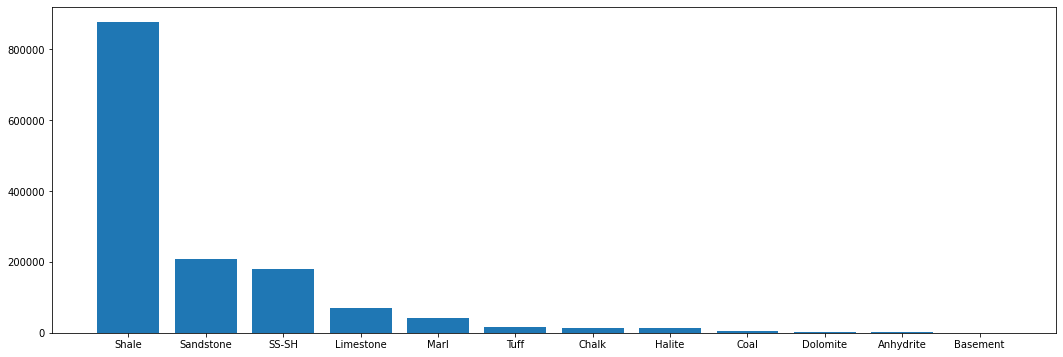

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(labels, height=df.LITHO_NUM.value_counts())

In [14]:
df.dtypes

WELL          object
DEPTH_MD     float64
X_LOC        float64
Y_LOC        float64
Z_LOC        float64
GROUP         object
FORMATION     object
CALI         float64
RSHA         float64
RMED         float64
RDEP         float64
RHOB         float64
GR           float64
SGR          float64
NPHI         float64
PEF          float64
DTC          float64
SP           float64
BS           float64
ROP          float64
DTS          float64
DCAL         float64
DRHO         float64
MUDWEIGHT    float64
RMIC         float64
ROPA         float64
RXO          float64
LITHO_NUM      int64
dtype: object

## 5. Building models

### Scoring models

In [24]:
# Loading penalty matrix used for scoring
A = np.load('D:\Datasets\penalty_matrix.npy')
A[2,2] # Same values won't reduce the score

# Score the model
def score_model(Y_true, Y_pred):
    S = 0.0
    Y_true = Y_true.astype(int)
    Y_pred = Y_pred.astype(int)
    for i in range(len(Y_true)):
        S -= A[Y_true[i], Y_pred[i]]
    return S/Y_true.shape[0]

### Baseline model
This model will leave out categorical features and not fill null values.

In [16]:
df_baseline = df.drop(['WELL', 'FORMATION', 'GROUP'], axis=1)

#### Splitting data into X and Y sets. 

In [41]:
# Defining X and Y train datasets
X_train_b = df_baseline[df['WELL'].isin(wells_train_list)].drop(['LITHO_NUM'], axis=1)
Y_train_b = df_baseline['LITHO_NUM'][df['WELL'].isin(wells_train_list)].to_numpy()

X_valid_b = df_baseline[df['WELL'].isin(wells_valid_list)].drop(['LITHO_NUM'], axis=1)
Y_valid_b = df_baseline['LITHO_NUM'][df['WELL'].isin(wells_valid_list)].to_numpy()

X_test_b = df_baseline[df['WELL'].isin(wells_test_list)].drop(['LITHO_NUM'], axis=1)
Y_test_b = df_baseline['LITHO_NUM'][df['WELL'].isin(wells_test_list)].to_numpy()

In [30]:
X_train_b.shape, Y_train_b.shape, X_valid_b.shape, Y_valid_b.shape

((1170511, 24), (1170511,), (136786, 24), (136786,))

In [72]:
# Training baseline model
baseline_model = XGBClassifier(n_estimators=30, learning_rate=0.1, max_depth=3, seed=82).fit(X_train_b, Y_train_b)

In [73]:
# Predicting on the train and valid dataset
Y_valid_b_pred = baseline_model.predict(X_valid_b)
Y_test_b_pred = baseline_model.predict(X_test_b)

In [75]:
# Scoring baseline model applying the score_model function in valid dataset 
score =  score_model(Y_valid_b, Y_valid_b_pred)
print("Contest metric:", round(1 + score/2, 2),"(",round(score,2),")")

Contest metric: 0.68 ( -0.65 )


In [74]:
# Scoring baseline model applying the score_model function in test dataset 
score =  score_model(Y_test_b, Y_test_b_pred)
print("Contest metric:", round(1 + score/2, 2),"(",round(score,2),")")

Contest metric: 0.62 ( -0.75 )


#### Evaluating features to improve the model

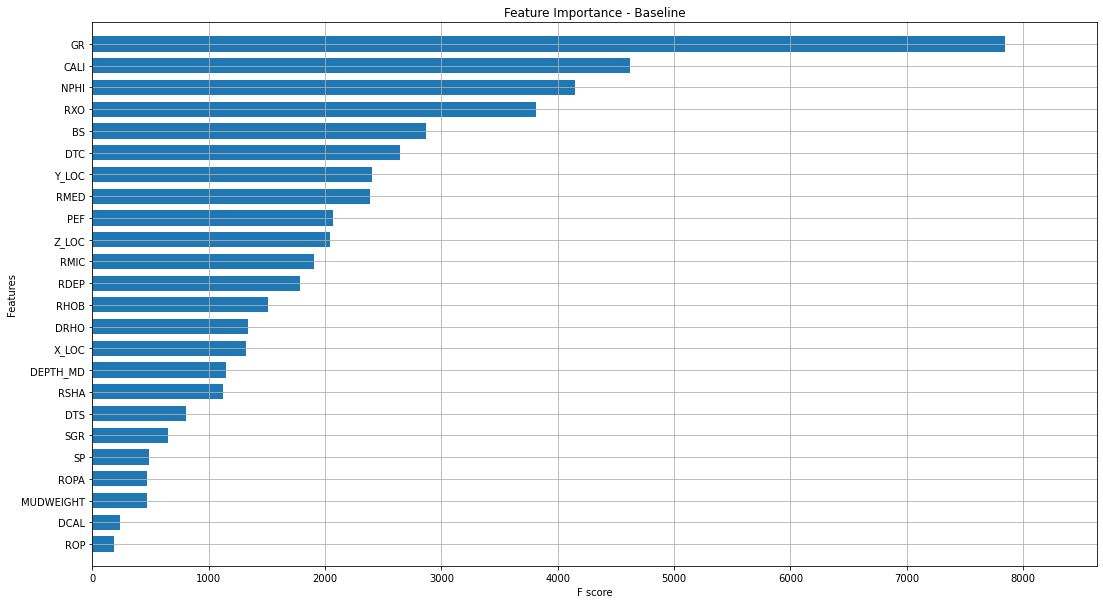

In [79]:
# Measuring the features importance
plt.rcParams['figure.figsize'] = (18, 10)
plot_importance(booster = baseline_model, height = 0.7, importance_type = 'gain', show_values = False, title = 'Feature Importance - Baseline');

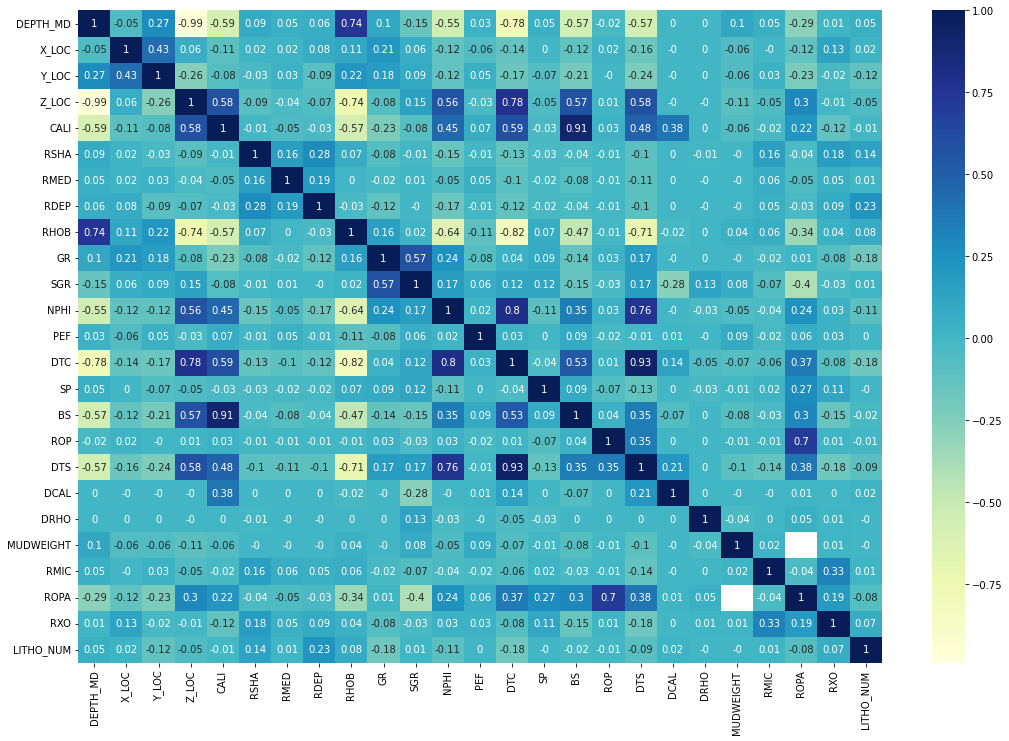

In [77]:
# Plotting correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(round(df.corr(),2), annot=True, cmap='YlGnBu');

<AxesSubplot:>

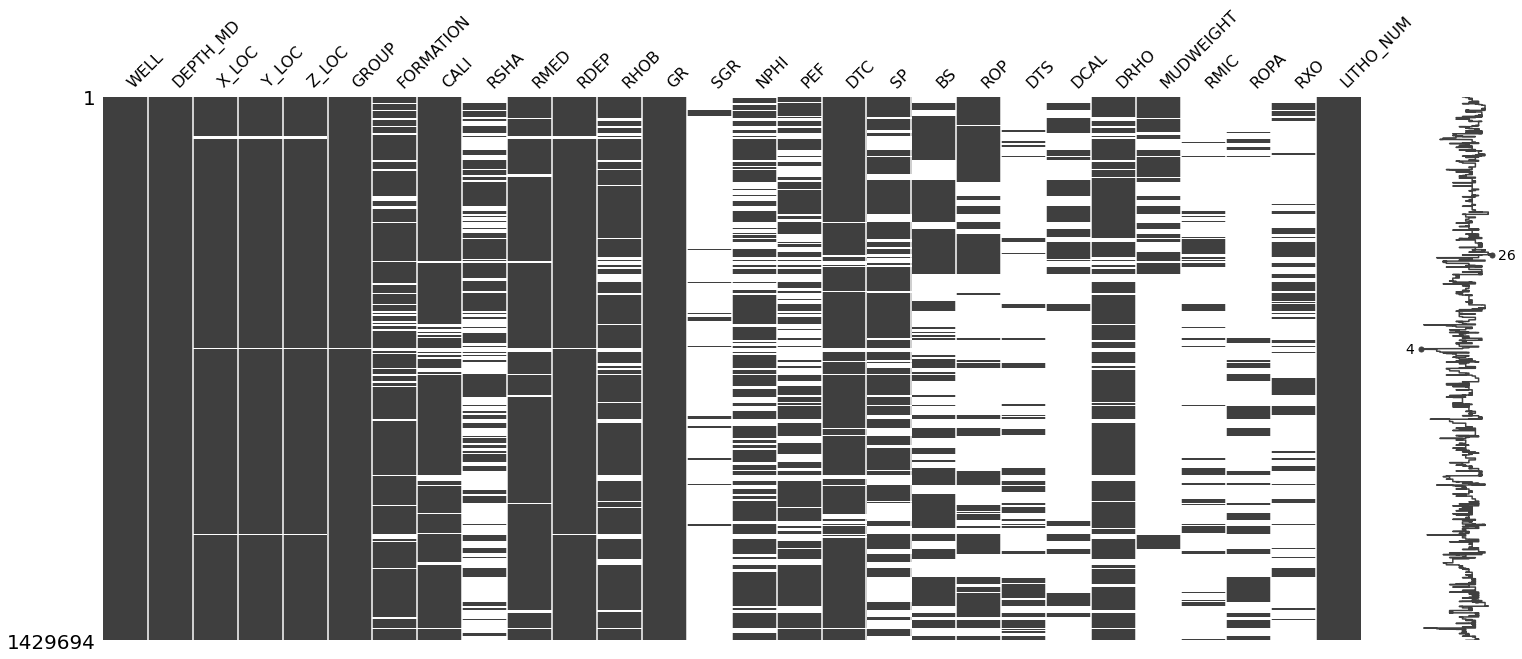

In [78]:
# Plot missing values of the data
msno.matrix(df)

#### Checking for outliers

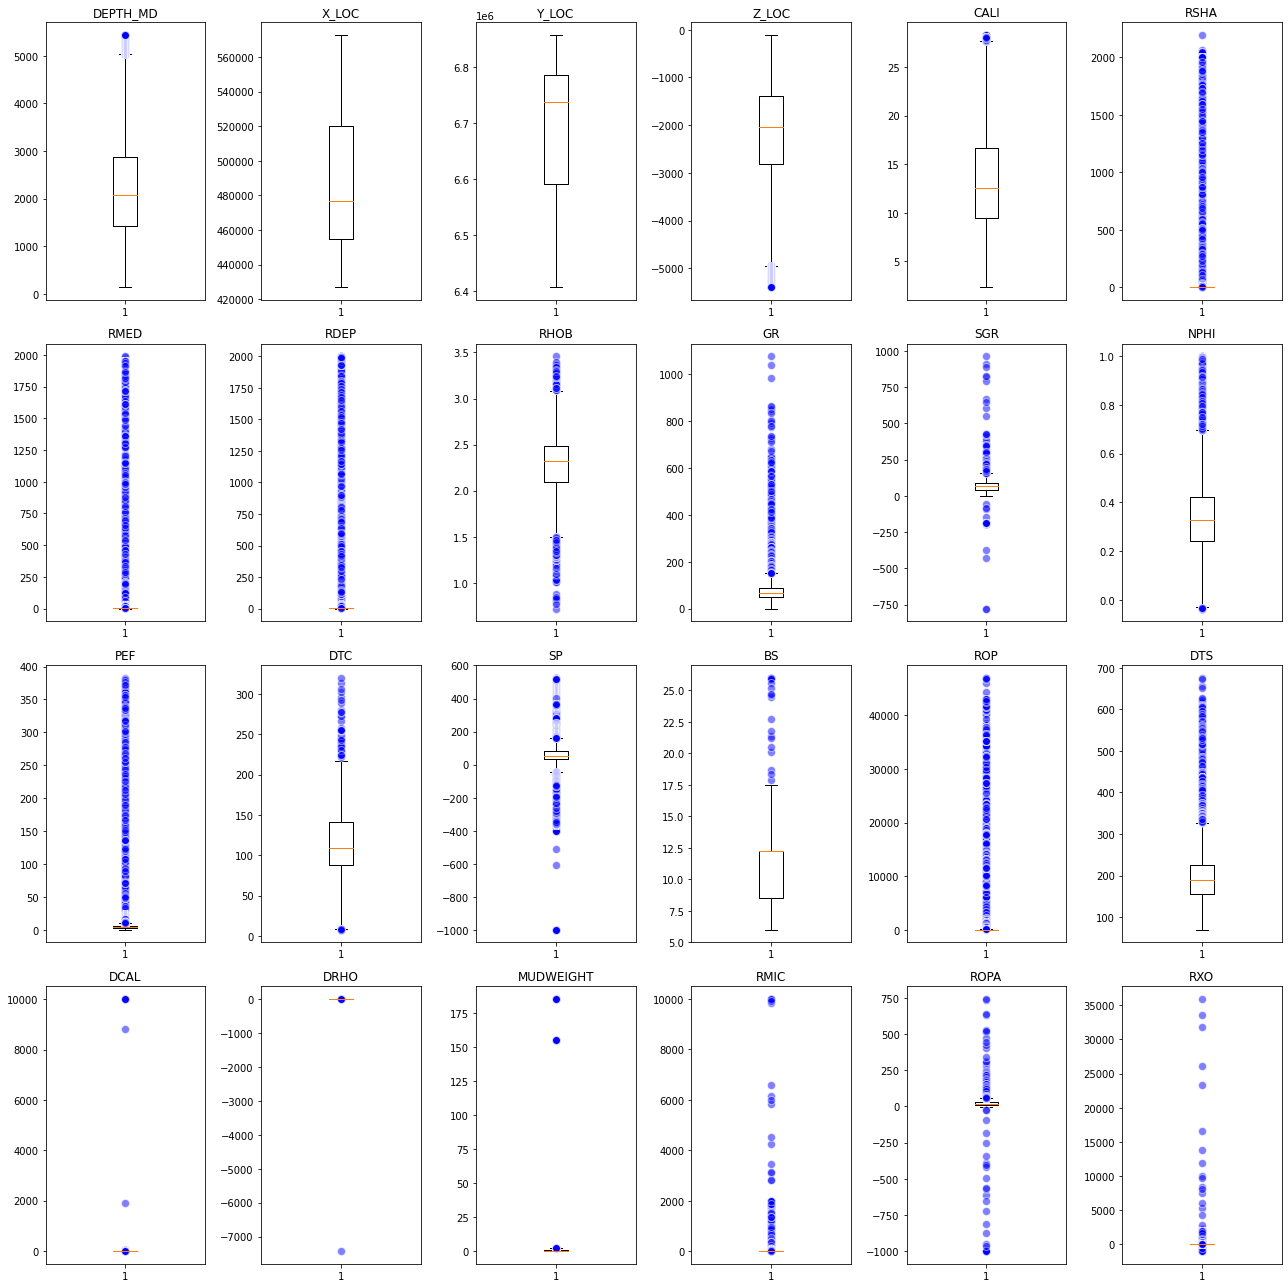

In [42]:
fig, axs = plt.subplots(4, int(len(X_train_b.columns)/4), figsize=(18, 18))
red_circle = dict(markerfacecolor='blue', marker='o', markersize=8, alpha=0.5, markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    ax.boxplot(X_train_b.iloc[:, i].dropna(), flierprops=red_circle)
    ax.set_title(X_train_b.columns[i])
    ax.tick_params(axis='x', labelsize=10)

plt.tight_layout();

### Model_1: Reducing number of variables and filling the missing data

In [12]:
# Drop the features with correlation more than 0.8 and have almost importance in the model. Also, features with more missing values.
df_1 = df.drop(['DTS', 'RXO','ROPA', 'SGR'], axis=1)
df_1.shape

(1429694, 24)

#### Filling missing values

In [13]:
# Filling missing values with median
def fill_miss_med_val(data):
    for label, content in data.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                data[label] = content.fillna(-999)

        elif not pd.api.types.is_numeric_dtype(content):
            data[label + '_is_null'] = pd.isnull(content)
            # Add binary column where missing values are
            data[label] = pd.Categorical(content).codes + 1
    return data.shape

In [14]:
# Appying the function to the dataset
fill_miss_med_val(df_1)

(1429694, 27)

In [15]:
# Splitting the traning df_1 into X and Y
X_train_1 = df_1.iloc[:len(data)].drop(['LITHO_NUM'], axis=1)
Y_train_1 = df_1['LITHO_NUM'].iloc[:len(data)].to_numpy()

X_valid_1 = df_1.iloc[len(data):len(data)+len(valid_data)].drop(['LITHO_NUM'], axis=1)
Y_valid_1 = df_1['LITHO_NUM'].iloc[len(data):len(data)+len(valid_data)].to_numpy()

X_test_1 = df_1.iloc[len(data)+len(valid_data):].drop(['LITHO_NUM'], axis=1)
Y_test_1 = df_1['LITHO_NUM'].iloc[len(data)+len(valid_data):].to_numpy()

In [21]:
# Verify if there are any missing values
X_train_1.isnull().sum()

WELL                 0
DEPTH_MD             0
X_LOC                0
Y_LOC                0
Z_LOC                0
GROUP                0
FORMATION            0
CALI                 0
RSHA                 0
RMED                 0
RDEP                 0
RHOB                 0
GR                   0
NPHI                 0
PEF                  0
DTC                  0
SP                   0
BS                   0
ROP                  0
DCAL                 0
DRHO                 0
MUDWEIGHT            0
RMIC                 0
WELL_is_null         0
GROUP_is_null        0
FORMATION_is_null    0
dtype: int64

In [170]:
# Training model_1
xgb_model_1 = XGBClassifier(n_estimators=30, learning_rate=0.1, max_depth=3, seed=82).fit(X_train_1, Y_train_1)

In [171]:
# Predicting on the valid and test dataset
Y_valid_1_pred = xgb_model_1.predict(X_valid_1)
Y_test_1_pred = xgb_model_1.predict(X_test_1)

In [172]:
# Scoring model_1 valid dataset
score =  score_model(Y_valid_1, Y_valid_1_pred)
print("Contest metric:", round(1 + score/2, 2),"(",round(score,2),")")

Contest metric: 0.7 ( -0.6 )


In [173]:
# Scoring model_1 test dataset
score =  score_model(Y_test_1, Y_test_1_pred)
print("Contest metric:", round(1 + score/2, 2),"(",round(score,2),")")

Contest metric: 0.66 ( -0.68 )


### Model_2: Using data augmentation based on DEPTH_MD

In [16]:
# Copy datasets for model_2
X_train_2 = X_train_1.copy()
X_valid_2 = X_valid_1.copy()
X_test_2 = X_test_1.copy()

Y_train_2 = Y_train_1.copy()
Y_valid_2 = Y_valid_1.copy()
Y_test_2 = Y_test_1.copy()

In [17]:
# This step easies the process
X_train_wells_2 = X_train_2.WELL.values
X_valid_wells_2 = X_valid_2.WELL.values
X_test_wells_2 = X_test_2.WELL.values

X_train_depth_2 = X_train_2.DEPTH_MD.values
X_valid_depth_2 = X_valid_2.DEPTH_MD.values
X_test_depth_2 = X_test_2.DEPTH_MD.values

In [18]:
# Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
# Link : https://github.com/seg/2016-ml-contest/tree/master/ispl

# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows


In [19]:
X_train_au_2, padded_rows_tr = augment_features(pd.DataFrame(X_train_2).values, X_train_wells_2, X_train_depth_2, N_neig=1)
X_valid_au_2, padded_rows_v = augment_features(pd.DataFrame(X_valid_2).values, X_valid_wells_2, X_valid_depth_2, N_neig=1)
X_test_au_2, padded_rows_te = augment_features(pd.DataFrame(X_test_2).values, X_test_wells_2, X_test_depth_2, N_neig=1)
X_train_au_2.shape, X_valid_au_2.shape, X_test_au_2.shape 

((1170511, 104), (136786, 104), (122397, 104))

In [46]:
# Train model using RandomGridSearchCV to have snapshot of the best parameters
xgb_r_grid = {'n_estimators': np.arange(10,100,10), 'subsample':[0.5,0.8], 'learning_rate':[0.1,0.05,0.01], 'objective':['multi:softmax', 'multi:softprob'], 'max_depth':[3,4,5,6,7,8,9,10], 'lambda':[1,10,100]}

xgb_model_2 = RandomizedSearchCV(XGBClassifier(n_jobs=-1, random_state=82), param_distributions=xgb_r_grid, n_iter=2, cv=3, verbose=True)

xgb_model_2.fit(X_train_au_2, Y_train_2)

xgb_model_2.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [21]:
# Training model_2
xgb_model_2 = XGBClassifier(n_estimators=30, learning_rate=0.1, max_depth=3, seed=82).fit(X_train_au_2, Y_train_2)

In [22]:
# Predicting on the valid and test dataset
Y_valid_2_pred = xgb_model_2.predict(X_valid_au_2)
Y_test_2_pred = xgb_model_2.predict(X_test_au_2)

In [25]:
# Scoring model_2 valid dataset
score =  score_model(Y_valid_2, Y_valid_2_pred)
print("Contest metric:", round(1 + score/2, 2),"(",round(score,2),")")

Contest metric: 0.55 ( -0.91 )


In [26]:
# Scoring model_2 test dataset
score =  score_model(Y_test_2, Y_test_2_pred)
print("Contest metric:", round(1 + score/2, 2),"(",round(score,2),")")

Contest metric: 0.57 ( -0.87 )
